# Abalone Rings Regression using Dense Layers

In [67]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats

In [68]:
torch.manual_seed(42)
np.random.seed(42)

In [69]:
data = pd.read_csv('data/abalone.csv')

In [70]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop('Rings', axis=1).values
y = data['Rings'].values

In [71]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [72]:
class AbaloneNet(nn.Module):
    def __init__(self, input_size):
        super(AbaloneNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [73]:
input_size = X_train_scaled.shape[1]
net = AbaloneNet(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [74]:
num_epochs = 1000
batch_size = 128
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    net.eval()
    with torch.no_grad():
        train_predictions = net(X_train_tensor)
        train_loss = criterion(train_predictions, y_train_tensor)
        train_losses.append(train_loss.item())
        
        val_predictions = net(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [100/1000], Train Loss: 4.4067, Val Loss: 4.3432
Epoch [200/1000], Train Loss: 4.1382, Val Loss: 4.2040
Epoch [300/1000], Train Loss: 3.9760, Val Loss: 4.1899
Epoch [400/1000], Train Loss: 3.8210, Val Loss: 4.1473
Epoch [500/1000], Train Loss: 3.7190, Val Loss: 4.0964
Epoch [600/1000], Train Loss: 3.6341, Val Loss: 4.1300
Epoch [700/1000], Train Loss: 3.5308, Val Loss: 4.1039
Epoch [800/1000], Train Loss: 3.4448, Val Loss: 4.0481
Epoch [900/1000], Train Loss: 3.3324, Val Loss: 4.0850
Epoch [1000/1000], Train Loss: 3.2309, Val Loss: 4.0491


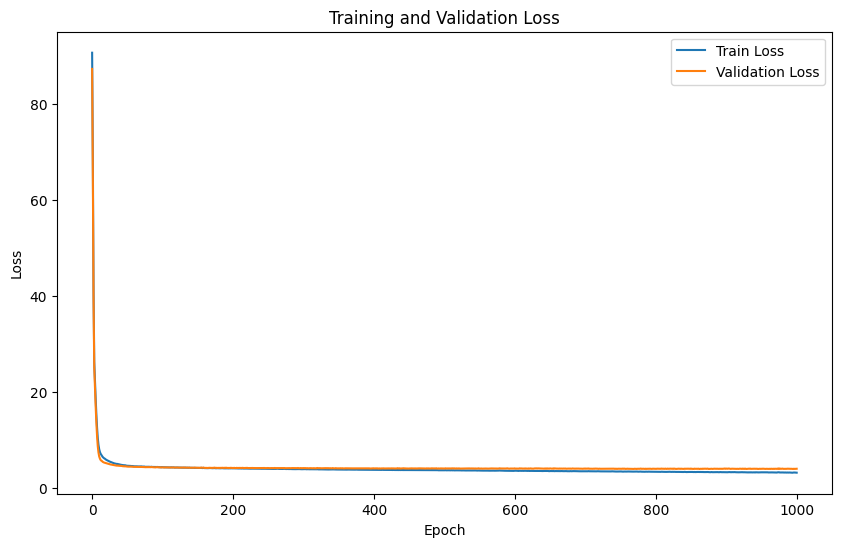

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [76]:
net.eval()
with torch.no_grad():
    y_pred = net(X_test_tensor).numpy().flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Final Results:')
print(f'\tMean Absolute Error: {mae:.4f}')
print(f'\tMean Squared Error: {mse:.4f}')
print(f'\tr2 Score: {r2:.4f}')

Final Results:
	Mean Absolute Error: 1.4309
	Mean Squared Error: 4.0491
	r2 Score: 0.6013


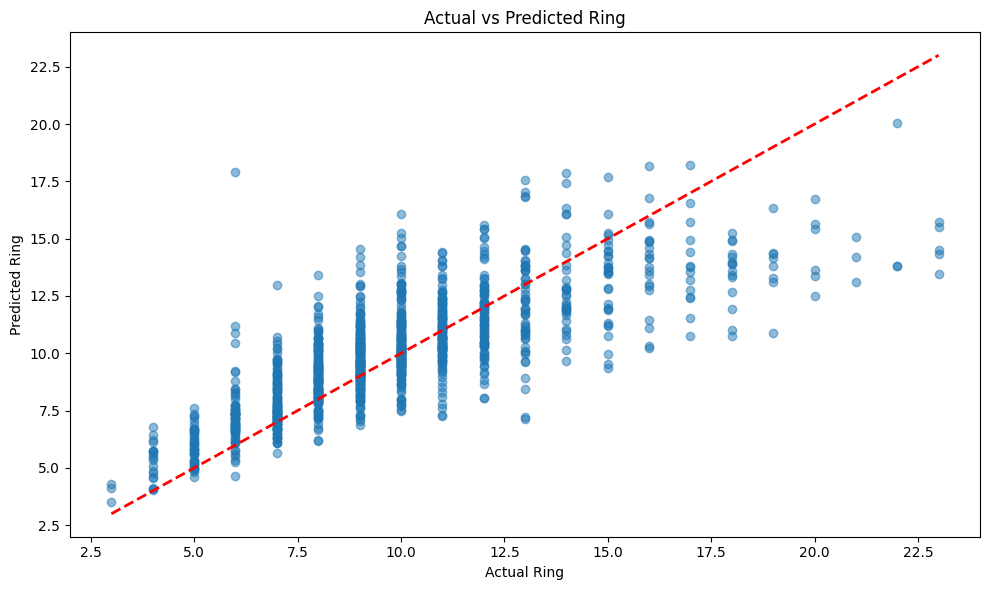

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ring')
plt.ylabel('Predicted Ring')
plt.title('Actual vs Predicted Ring')
plt.tight_layout()
plt.show()
plt.close()

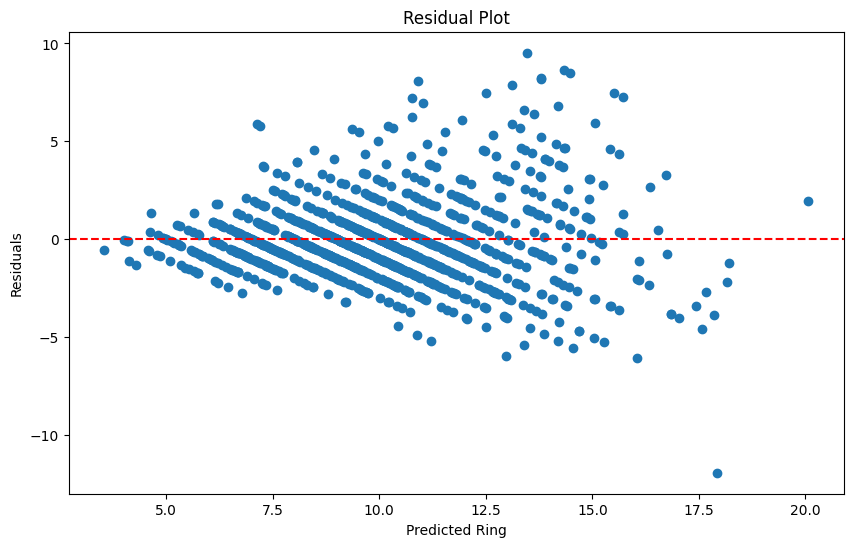

In [78]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Ring')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
plt.close()

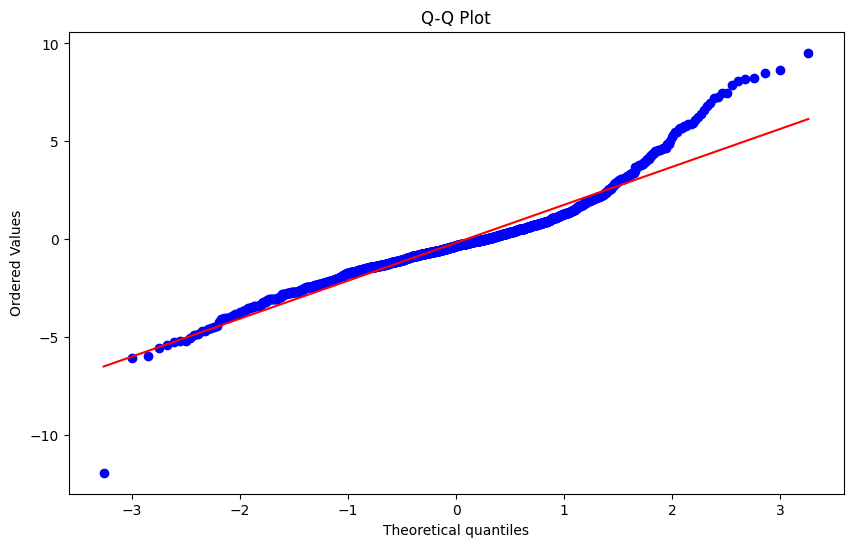

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot")
plt.show()
plt.close()

In [80]:
feature_importance = []
for i in range(input_size):
    X_test_mod = X_test_scaled.copy()
    X_test_mod[:, i] = 0
    X_test_mod_tensor = torch.FloatTensor(X_test_mod)
    with torch.no_grad():
        y_pred_mod = net(X_test_mod_tensor).numpy().flatten()
    mse_mod = mean_squared_error(y_test, y_pred_mod)
    importance = mse_mod - mse
    feature_importance.append(importance)

feature_importance = pd.DataFrame({
    'feature': data.drop('Rings', axis=1).columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
          feature  importance
5    Whole_weight   15.040522
6  Shucked_weight    7.822407
8    Shell_weight    1.086837
2          Length    0.754697
3        Diameter    0.641279
7  Viscera_weight    0.596669
4          Height    0.422112
0              id    0.354412
1             Sex    0.214833
